# Dropout


In [1]:
!pip install mxnet
!pip install d2l

     |████████████████████████████████| 25.4MB 1.3MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
  Created wheel for d2l: filename=d2l-0.10.1-cp36-none-any.whl size=16622 sha256=61b374ef0b6db90eeb6f18cc62e4b3fa450fb6c76d73175212114c6905ec6212
  Stored in directory: /root/.cache/pip/wheels/60/35/5d/df7f13dd4b012de688ffcc516091c6cd67c765dc64c9d1f43f
Successfully built d2l


In [0]:
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import loss as gloss, nn

## Dropout from Scratch

In [0]:
def dropout(X, drop_prob):
    assert 0 <= drop_prob <= 1
    # In this case, all elements are dropped out.
    if drop_prob == 1:
        return X.zeros_like()
    mask = nd.random.uniform(0, 1, X.shape) > drop_prob
    return mask * X / (1.0-drop_prob)

## Sanity Test 

In [3]:
X = nd.arange(16).reshape((2, 8))
print(dropout(X, 0))
print(dropout(X, 0.5))
print(dropout(X, 1))


[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
<NDArray 2x8 @cpu(0)>

[[ 0.  0.  0.  0.  8. 10. 12.  0.]
 [16.  0. 20. 22.  0.  0.  0. 30.]]
<NDArray 2x8 @cpu(0)>

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 2x8 @cpu(0)>


### Defining Model Parameters


In [0]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 1024, 2048

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens1))
b1 = nd.zeros(num_hiddens1)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens1, num_hiddens2))
b2 = nd.zeros(num_hiddens2)
W3 = nd.random.normal(scale=0.01, shape=(num_hiddens2, num_outputs))
b3 = nd.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

### Define the Model

In [0]:


def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = (nd.dot(X, W1) + b1).relu()
    if autograd.is_training():        # Use dropout only when training the model.
        H1 = dropout(H1, drop_prob1)  # Add a dropout layer after the first fully connected layer.
    H2 = (nd.dot(H1, W2) + b2).relu()
    if autograd.is_training():
        H2 = dropout(H2, drop_prob2)  # Add a dropout layer after the second fully connected layer.
    return nd.dot(H2, W3) + b3

### Training and Testing

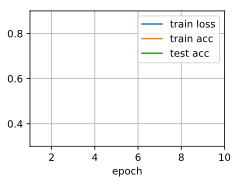

In [0]:
drop_prob1, drop_prob2 = 0.2, 0.5
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gloss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(params, lr, batch_size))

In [0]:
test_accuracy = d2l.evaluate_accuracy(net,test_iter)
train_accuracy = d2l.evaluate_accuracy(net,train_iter)
print("Loss: %s, Train_acc %s, Test_acc %s" %(loss, train_accuracy, test_accuracy))


In [0]:
test_accuracy

## Dropout in Gluon

In [0]:
net = nn.Sequential()
net.add(nn.Dense(num_hiddens1, activation="relu"),
        nn.Dropout(drop_prob1),  # Add a dropout layer after the first fully connected layer.
        nn.Dense(num_hiddens2, activation="relu"),
        nn.Dropout(drop_prob2),  # Add a dropout layer after the second fully connected layer.
        nn.Dense(num_outputs))
net.initialize(init.Normal(sigma=0.01))

### Training

In [0]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
             lambda batch_size: d2l.sgd(params, lr, batch_size))

In [0]:
test_accuracy = d2l.evaluate_accuracy(net,test_iter)
train_accuracy = d2l.evaluate_accuracy(net,train_iter)
print("Loss: %s, Train_acc %s, Test_acc %s" %(loss, train_accuracy, test_accuracy))

# Dropout in Keras

In [0]:
import keras


from keras.layers import Dense, Flatten
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dropout

In [0]:
# grab the Fashion MNIST dataset (if this is your first time running
# this the dataset will be automatically downloaded)
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
 
# one-hot encode the training and testing labels
trainY = np_utils.to_categorical(trainY, 10)
testY = np_utils.to_categorical(testY, 10)
 
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat","sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [0]:
width = 28
height= 28
depth=1
classes=10
batch_size, num_epochs = 256, 10
model = Sequential()
model.add(Flatten(input_shape=(height, width, depth)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10))

sgd=keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(trainX, trainY, batch_size=batch_size, epochs=num_epochs, shuffle=False)